# Explore data base from GoodReads


- link: [goodreads](https://www.goodreads.com/)  
- nice tuto on [NLP-LDA analysis](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#10diagnosemodelperformancewithperplexityandloglikelihood)

In [136]:
# lib
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import LatentDirichletAllocation

# plot with PyLDAvis library
import pyLDAvis.sklearn

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [137]:
# loc functions
def display_topics2(model, feature_names, n_top_words=25):
    """create a panda data frame of the top words present in each topics.
    Inputs:
        - model: fitted model, from where we will extract the results (numeric)
        - feature_names: list of string (words used in the model)
        - no_top_words: int, number of top words per topics we want to extract
    Outputs:
        - DataFrame
        """
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict["Topic%d" % (topic_idx+1)] = [feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(word_dict).T

# 1.0 inputs

In [2]:
# load tag list
tags = pd.read_csv('tags.csv')
tags = tags.set_index('tag_id')
tags_d = tags.to_dict()['tag_name']
tags.head()

,tag_name
tag_id,
0,-
1,--1-
2,--10-
3,--12-
4,--122-


In [4]:
# Load book info
tag_books = pd.read_csv('book_tags.csv')
tag_books['tag_id']= tag_books['tag_id'].map(tags_d)
tag_books.tag_id = tag_books.tag_id.str.lower()
tag_books.head()

,goodreads_book_id,tag_id,count
0,1,to-read,167697
1,1,fantasy,37174
2,1,favorites,34173
3,1,currently-reading,12986
4,1,young-adult,12716


# 2.0 creation of reference tags list (250)

In [54]:
#remove some unrelevan tags (grep-remove)
remove_grep = ['favorit', 'read', 'audio', 'kindle', '-i-', 'favourit', 'ebook', 
               'stars', 'owned', 'book-club', 'default', 'library', 'to-buy', 'i-own', 'audible',
              'did-not-finish', 'maybe', 'book', 'abandoned', 'adult', 'fiction', 'finish', 'wish', 'own', 'روايات']

to_remove = []
for word in remove_grep:
    mask = tags.tag_name.str.contains(word)
    to_remove = to_remove + tags.loc[mask,'tag_name'].tolist()
    
mask = tag_books.tag_id.isin(to_remove)
tag_books = tag_books.loc[~mask,:]

In [138]:
# tag books selection: we keep the first n=20 tags for each book (we ignore the rest)
tag_books = tag_books.sort_values(['goodreads_book_id','count'], ascending=False)
book_ids_li = list(tag_books.goodreads_book_id.unique())
n = 10
li = []
for book in tqdm(book_ids_li):
    mask = tag_books.goodreads_book_id == book
    li.append(tag_books.loc[mask,:].head(n))

# on the remaning tags, keep the 250 most frequent
tag_books_s =  pd.concat(li, axis=0, ignore_index=True)
top_250_tags = list(tag_books_s.groupby('tag_id')['count'].sum().sort_values(ascending=False)[:250].index)

100%|██████████| 10000/10000 [00:18<00:00, 538.62it/s]


Text(0.5, 0, 'Words frequency in the corpus [number of occurences]')

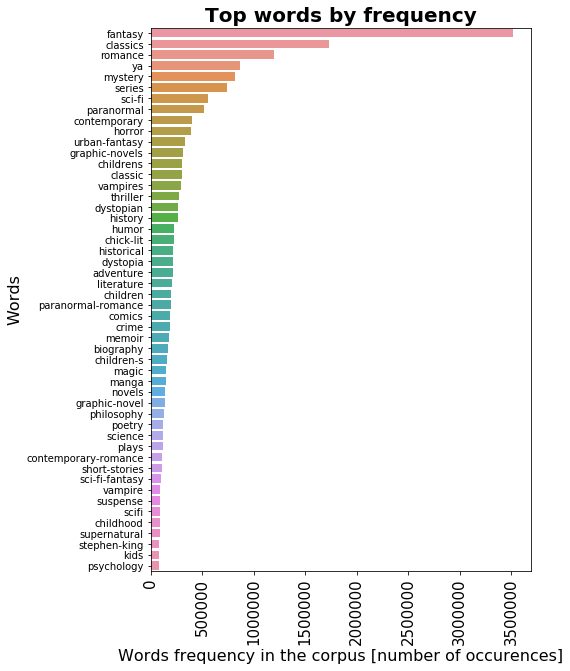

In [63]:
# plot top 50 tags
import seaborn as sns
import matplotlib.pyplot as plt

X = tag_books_s.groupby('tag_id')['count'].sum().sort_values(ascending=False)[:50]

# plot
fig = plt.figure(figsize=(15,10))
plt.title("Top words by frequency", fontweight="bold", size=20)
plt.xticks(rotation=90, size=15)
sns.barplot(x=X.values, y=X.index,  label="Total");
plt.ylabel("Words", size=16)
plt.xlabel("Words frequency in the corpus [number of occurences]", size=16)

# 3.0 format data to get a corpora for the LDA model
the format should be a list or serie of text

In [139]:
# create corpora serie
corpora = tag_books_s.groupby('goodreads_book_id')['tag_id'].apply(' '.join)
corpora.sample(10)

goodreads_book_id
228296      thriller mystery paranormal fantasy supernatur...
48318       philosophy fantasy novel mystery jostein-gaard...
33          fantasy classics classic tolkien adventure sci...
887201      art fantasy mythology faeries fairy-tales folk...
10429025    angels paranormal ya fantasy romance series pa...
89884       colorado contemporary series novels literature...
23156040    italy italian series novels contemporary femin...
9762        self-help psychology spirituality personal-dev...
10058       history war military wwii world-war-ii biograp...
875441      historical canadian slavery canada africa cana...
Name: tag_id, dtype: object

# LDA Model
The idea is to create some main topics (16 here). This is done by analysing the tags for each books.
The model would be able to classify each book on one of a major topic.

In [65]:
# term_frequency table
tf_vectorizer = CountVectorizer(token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]", vocabulary=top_250_tags)
tf = tf_vectorizer.fit_transform(corpora)
feature_names = tf_vectorizer.get_feature_names()
print('tf shape :', tf.shape)
pd.DataFrame(tf.toarray(), columns=feature_names).head()

In [74]:
# model fit
lda_tf = LatentDirichletAllocation(n_components=16, 
                                random_state=2).fit(tf)

In [75]:
# results visualisation
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf, tf, tf_vectorizer, mds='tsne', sort_topics=False)
panel

D:\Users\mclere\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       48.146263 -255.147583       1        1   6.747227
1     -263.727356   64.996292       2        1   8.933361
2       29.008585   26.685223       3        1   8.555144
3     -280.403412 -125.624779       4        1   4.650390
4     -132.064148  -33.751495       5        1   4.082477
5      306.134613  -91.459259       6        1   3.549723
6     -122.327888 -210.116577       7        1   2.571381
7       -8.198215 -116.927246       8        1   5.985259
8      200.398758   51.904755       9        1   7.154626
9       82.277458  184.820236      10        1   4.160517
10     -70.507118 -382.293182      11        1   5.151855
11     119.395294 -404.036469      12        1   9.178968
12     139.891891 -109.499878      13        1   5.425503
13     229.073349 -257.173065      14        1   5.937536
14    -247.529083 -313.368652      15        1   7.423822
15     -97.243942  144.539398      16        1  10.492210, topic_info=     Category         Freq               Term        Total  loglift  logprob
term                                                                        
8     Default  2174.000000       contemporary  2174.000000  30.0000  30.0000
0     Default  3341.000000            fantasy  3341.000000  29.0000  29.0000
4     Default  2126.000000            mystery  2126.000000  28.0000  28.0000
20    Default  1240.000000         historical  1240.000000  27.0000  27.0000
33    Default  1529.000000             novels  1529.000000  26.0000  26.0000
15    Default  1389.000000           thriller  1389.000000  25.0000  25.0000
2     Default  2942.000000            romance  2942.000000  24.0000  24.0000
22    Default  1294.000000          adventure  1294.000000  23.0000  23.0000
41    Default   882.000000     sci-fi-fantasy   882.000000  22.0000  22.0000
23    Default  1303.000000         literature  1303.000000  21.0000  21.0000
19    Default  1018.000000          chick-lit  1018.000000  20.0000  20.0000
3     Default  1928.000000                 ya  1928.000000  19.0000  19.0000
27    Default  1090.000000              crime  1090.000000  18.0000  18.0000
7     Default  1120.000000         paranormal  1120.000000  17.0000  17.0000
12    Default   959.000000          childrens   959.000000  16.0000  16.0000
43    Default  1035.000000           suspense  1035.000000  15.0000  15.0000
29    Default   752.000000          biography   752.000000  14.0000  14.0000
24    Default   817.000000           children   817.000000  13.0000  13.0000
55    Default   869.000000   mystery-thriller   869.000000  12.0000  12.0000
6     Default  1042.000000             sci-fi  1042.000000  11.0000  11.0000
17    Default  1030.000000            history  1030.000000  10.0000  10.0000
30    Default   726.000000         children-s   726.000000   9.0000   9.0000
5     Default  3866.000000             series  3866.000000   8.0000   8.0000
18    Default  1019.000000              humor  1019.000000   7.0000   7.0000
11    Default   487.000000     graphic-novels   487.000000   6.0000   6.0000
9     Default   767.000000             horror   767.000000   5.0000   5.0000
28    Default   598.000000             memoir   598.000000   4.0000   4.0000
87    Default   606.000000              novel   606.000000   3.0000   3.0000
1     Default  1670.000000           classics  1670.000000   2.0000   2.0000
10    Default   588.000000      urban-fantasy   588.000000   1.0000   1.0000
...       ...          ...                ...          ...      ...      ...
93    Topic16   473.663921          thrillers   476.552156   2.2485  -2.8147
216   Topic16    77.864966          patterson    78.825544   2.2423  -4.6203
83    Topic16    39.910984    agatha-christie    40.871562   2.2308  -5.2886
108   Topic16    34.217887    janet-evanovich    35.178465   2.2269  -5.4425
201   Topic16    32.320188     david-baldacci    33.280766   2.2

In [76]:
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity tf: ", lda_tf.perplexity(tf))

Perplexity tf:  52.6810358373022


In [79]:
topics_df = display_topics2(lda_tf, feature_names)
topics_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Topic1,biography,memoir,history,memoirs,biography-memoir,autobiography,biographies,historical,politics,war,...,military,humor,holocaust,true-crime,science,feminism,classics,african-american,music,psychology
Topic2,novels,literature,novel,classics,contemporary,american,classic,1001,american-literature,short-stories,...,historical,family,philosophy,japan,african-american,magical-realism,india,pulitzer,canadian,feminism
Topic3,childrens,children,children-s,kids,childhood,middle-grade,classics,animals,ya,fantasy,...,adventure,newbery,poetry,caldecott,school,mystery,family,friendship,fairy-tales,christmas
Topic4,humor,humour,comedy,funny,classics,classic,school,literature,plays,drama,...,fantasy,terry-pratchett,pratchett,short-stories,discworld,russian,19th-century,for-school,russian-literature,british
Topic5,sci-fi,dystopia,dystopian,fantasy,series,ya,post-apocalyptic,romance,adventure,short-stories,...,aliens,thriller,dnf,war,hunger-games,love-triangle,mystery,steampunk,african-american,christmas


In [80]:
# definie topic name as the merge of the 3 fists tags
topics_df['name'] = topics_df[0] + ' | ' + topics_df[1]+ ' | ' + topics_df[2]
topics_df['name']

Topic1                biography | memoir | history
Topic2                 novels | literature | novel
Topic3           childrens | children | children-s
Topic4                     humor | humour | comedy
Topic5               sci-fi | dystopia | dystopian
Topic6     graphic-novels | graphic-novel | comics
Topic7                    fantasy | lgbt | romance
Topic8           philosophy | religion | self-help
Topic9             contemporary | romance | series
Topic10                horror | mystery | thriller
Topic11             historical | history | romance
Topic12              paranormal | fantasy | series
Topic13                    adventure | series | ya
Topic14         contemporary | chick-lit | romance
Topic15          sci-fi-fantasy | fantasy | series
Topic16                 mystery | thriller | crime
Name: name, dtype: object

In [127]:
to_merge =  corpora.reset_index()
to_merge['topic'] =   pd.DataFrame(lda_tf.transform(tf), 
             columns=topics_df['name'].values).idxmax(axis=1)
to_merge.sample(10)

,goodreads_book_id,tag_id,topic
6940,6948436,england refugee survival africa immigration re...,historical | history | romance
2967,71622,civil-war historical history war southern amer...,historical | history | romance
6279,3188186,james-patterson mystery thriller patterson mic...,mystery | thriller | crime
1014,12349,food japan contemporary novels asian-american ...,novels | literature | novel
3108,77866,british literature historical contemporary eng...,historical | history | romance
2794,60931,fantasy sci-fi time-travel historical african-...,sci-fi-fantasy | fantasy | series
1246,15549,fantasy terry-brooks shannara sci-fi post-apoc...,sci-fi | dystopia | dystopian
5674,854757,romance chick-lit contemporary-romance contemp...,contemporary | chick-lit | romance
3728,117047,science evolution biology religion philosophy ...,philosophy | religion | self-help
3119,78508,history biography adventure travel american-hi...,biography | memoir | history


In [112]:
books_df = pd.read_csv('books.csv')
books_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [113]:
books_df.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

In [114]:
col_to_keep = ['goodreads_book_id', 'best_book_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 
               'title', 'language_code', 'average_rating',
       'ratings_count', 'image_url', 'small_image_url']
books_df = books_df.loc[:,col_to_keep]

In [116]:
books_df = pd.merge(books_df, to_merge, on='goodreads_book_id')

In [118]:
books_df.sort_values('best_book_id').loc[:,['authors', 'title', 'average_rating', 'topic']].head(50)

,authors,title,average_rating,topic
26,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...,4.54,adventure | series | ya
20,"J.K. Rowling, Mary GrandPré",Harry Potter and the Order of the Phoenix (Har...,4.46,adventure | series | ya
1,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4.44,adventure | series | ya
17,"J.K. Rowling, Mary GrandPré, Rufus Beck",Harry Potter and the Prisoner of Azkaban (Harr...,4.53,adventure | series | ya
23,"J.K. Rowling, Mary GrandPré",Harry Potter and the Goblet of Fire (Harry Pot...,4.53,adventure | series | ya
3274,"J.K. Rowling, Mary GrandPré","Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.77,adventure | series | ya
3752,J.K. Rowling,"Harry Potter Collection (Harry Potter, #1-6)",4.73,adventure | series | ya
336,Douglas Adams,The Ultimate Hitchhiker's Guide to the Galaxy,4.37,sci-fi-fantasy | fantasy | series
373,Bill Bryson,A Short History of Nearly Everything,4.19,philosophy | religion | self-help
1459,Bill Bryson,In a Sunburned Country,4.05,biography | memoir | history


In [128]:
selec = ['best_book_id', 'authors', 'title', 'average_rating','ratings_count', 'topic', 'tag_id']
books_df.sort_values('average_rating', ascending=False).loc[:,selec].head(50)

,best_book_id,authors,title,average_rating,ratings_count,topic,tag_id
3627,24812,Bill Watterson,The Complete Calvin and Hobbes,4.82,28900,graphic-novels | graphic-novel | comics,comics humor graphic-novels humour comic graph...
3274,8,"J.K. Rowling, Mary GrandPré","Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.77,33220,adventure | series | ya,fantasy harry-potter magic series ya j-k-rowli...
861,17332218,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)",4.77,73572,sci-fi-fantasy | fantasy | series,fantasy epic-fantasy brandon-sanderson high-fa...
8853,95602,Francine Rivers,Mark of the Lion Trilogy,4.76,9081,philosophy | religion | self-help,christian romance historical francine-rivers s...
7946,5031805,"Anonymous, Lane T. Dennis, Wayne A. Grudem",ESV Study Bible,4.76,8953,philosophy | religion | self-help,christian theology bibles bible christianity r...
4482,24814,Bill Watterson,It's a Magical World: A Calvin and Hobbes Coll...,4.75,22351,graphic-novels | graphic-novel | comics,comics humor graphic-novels humour comic comed...
6360,70489,Bill Watterson,There's Treasure Everywhere: A Calvin and Hobb...,4.74,16766,graphic-novels | graphic-novel | comics,comics humor graphic-novels comic humour calvi...
421,862041,J.K. Rowling,"Harry Potter Boxset (Harry Potter, #1-7)",4.74,190050,childrens | children | children-s,fantasy ya series adventure childrens classics...
3752,10,J.K. Rowling,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618,adventure | series | ya,fantasy harry-potter magic ya series childrens...
6919,24815,Bill Watterson,The Indispensable Calvin and Hobbes,4.73,14597,graphic-novels | graphic-novel | comics,comics humor graphic-novels humour graphic-nov...


In [125]:
mask = books_df.topic == 'philosophy | religion | self-help'
books_df.loc[mask,selec].sort_values('best_book_id').head(20)

,best_book_id,authors,title,average_rating,topic
373,21,Bill Bryson,A Short History of Nearly Everything,4.19,philosophy | religion | self-help
7682,98,"Heidi Murkoff, Sharon Mazel, Heidi Murkoff, Ar...",What to Expect the First Year (What to Expect),3.86,philosophy | religion | self-help
1968,475,Jared Diamond,Collapse: How Societies Choose to Fail or Succeed,3.92,philosophy | religion | self-help
8933,621,David Bach,The Automatic Millionaire: A Powerful One-Step...,3.90,philosophy | religion | self-help
545,629,Robert M. Pirsig,Zen and the Art of Motorcycle Maintenance: An ...,3.76,philosophy | religion | self-help
5119,647,Naomi Klein,No Logo,3.86,philosophy | religion | self-help
8687,665,"Ayn Rand, Nathaniel Branden",The Virtue of Selfishness: A New Concept of Eg...,3.47,philosophy | religion | self-help
6936,840,Donald A. Norman,The Design of Everyday Things,4.18,philosophy | religion | self-help
34,865,"Paulo Coelho, Alan R. Clarke",The Alchemist,3.82,philosophy | religion | self-help
4907,900,Neil Strauss,The Game: Penetrating the Secret Society of Pi...,3.73,philosophy | religion | self-help


In [129]:
mask = books_df.topic == 'philosophy | religion | self-help'
books_df.loc[mask,selec].sort_values('average_rating',ascending=False ).head(20)

,best_book_id,authors,title,average_rating,ratings_count,topic,tag_id
8853,95602,Francine Rivers,Mark of the Lion Trilogy,4.76,9081,philosophy | religion | self-help,christian romance historical francine-rivers s...
7946,5031805,"Anonymous, Lane T. Dennis, Wayne A. Grudem",ESV Study Bible,4.76,8953,philosophy | religion | self-help,christian theology bibles bible christianity r...
9075,2350129,The Church of Jesus Christ of Latter-day Saints,Preach My Gospel: A Guide To Missionary Service,4.71,9891,philosophy | religion | self-help,religious lds religion church spiritual religi...
5918,265205,"Anonymous, Ronald A. Beers, Ronald A. Beers",Life Application Study Bible: NIV,4.67,13614,philosophy | religion | self-help,christian religion bibles christianity bible r...
4777,5883777,Anonymous,The Holy Bible: English Standard Version,4.66,17863,philosophy | religion | self-help,religion christian bibles bible reference theo...
4867,481749,James E. Talmage,Jesus the Christ,4.63,17179,philosophy | religion | self-help,religious lds religión church spiritual inspir...
6901,596259,Gordon B. Hinckley,Standing for Something: 10 Neglected Virtues T...,4.61,12708,philosophy | religion | self-help,religious lds religion church inspirational se...
2235,280111,Anonymous,Holy Bible: New International Version,4.61,40430,philosophy | religion | self-help,religion christian classics bible christianity...
2939,46601,Francine Rivers,"An Echo in the Darkness (Mark of the Lion, #2)",4.60,32386,philosophy | religion | self-help,christian romance historical francine-rivers s...
1617,95617,"Francine Rivers, Richard Ferrone","A Voice in the Wind (Mark of the Lion, #1)",4.60,55556,philosophy | religion | self-help,christian romance historical francine-rivers s...


In [121]:
books_df.topic.unique()

array(['sci-fi | dystopia | dystopian', 'adventure | series | ya',
       'paranormal | fantasy | series', 'novels | literature | novel',
       'contemporary | romance | series',
       'sci-fi-fantasy | fantasy | series', 'mystery | thriller | crime',
       'historical | history | romance', 'humor | humour | comedy',
       'biography | memoir | history',
       'contemporary | chick-lit | romance',
       'philosophy | religion | self-help',
       'childrens | children | children-s', 'horror | mystery | thriller',
       'fantasy | lgbt | romance',
       'graphic-novels | graphic-novel | comics'], dtype=object)

In [135]:
# Grep
look_up_stg = 'self'
mask = books_df.tag_id.str.contains(look_up_stg)
books_df.loc[mask,selec].sort_values('average_rating',ascending=False ).head(20)

,best_book_id,authors,title,average_rating,ratings_count,topic,tag_id
6901,596259,Gordon B. Hinckley,Standing for Something: 10 Neglected Virtues T...,4.61,12708,philosophy | religion | self-help,religious lds religion church inspirational se...
7592,5986375,David Foster Wallace,"This Is Water: Some Thoughts, Delivered on a S...",4.53,13312,philosophy | religion | self-help,philosophy psychology dfw american essays essa...
6962,434764,Stephen E. Robinson,Believing Christ: The Parable of the Bicycle a...,4.51,12951,philosophy | religion | self-help,religious lds religion church inspirational sp...
6994,434535,James L. Ferrell,The Peacegiver: How Christ Offers to Heal Our ...,4.41,12313,philosophy | religion | self-help,religious lds inspirational church spiritual s...
9756,1145862,"Patty Lovell, David Catrow","Stand Tall, Molly Lou Melon",4.39,11397,childrens | children | children-s,childrens bullying children self-esteem childr...
3889,18054709,Stormie Omartian,The Power of a Praying Woman,4.38,10970,philosophy | religion | self-help,christian prayer christian-living spiritual ch...
1746,4499669,"Stephen Kendrick, Alex Kendrick",The Love Dare,4.37,41908,philosophy | religion | self-help,christian marriage self-help relationships rom...
6456,1055617,Spencer W. Kimball,The Miracle of Forgiveness,4.37,13795,philosophy | religion | self-help,religious religion lds church spiritual self-h...
7418,270435,Louise L. Hay,Heal Your Body: The Mental Causes for Physical...,4.34,11502,philosophy | religion | self-help,health self-help spirituality spiritual healin...
4849,14572,"Thich Nhat Hanh, Arnold Kotler, Dalai Lama XIV",Peace Is Every Step: The Path of Mindfulness i...,4.34,19152,philosophy | religion | self-help,spirituality buddhism philosophy spiritual min...
